In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df=pd.read_csv("AirPassengers (3).csv",index_col=['Month'],parse_dates=True)
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [27]:
df.describe

<bound method NDFrame.describe of             #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
...                 ...
1960-08-01          606
1960-09-01          508
1960-10-01          461
1960-11-01          390
1960-12-01          432

[144 rows x 1 columns]>

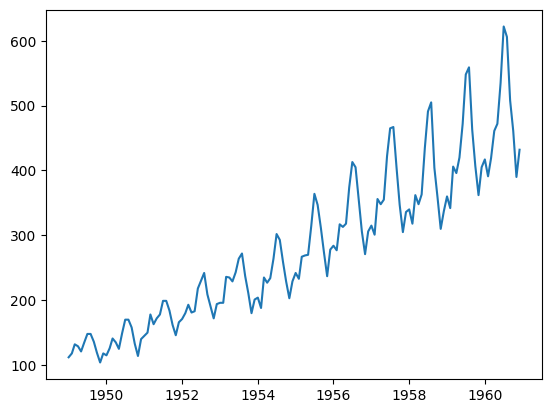

In [28]:
plt.plot(df['#Passengers'])

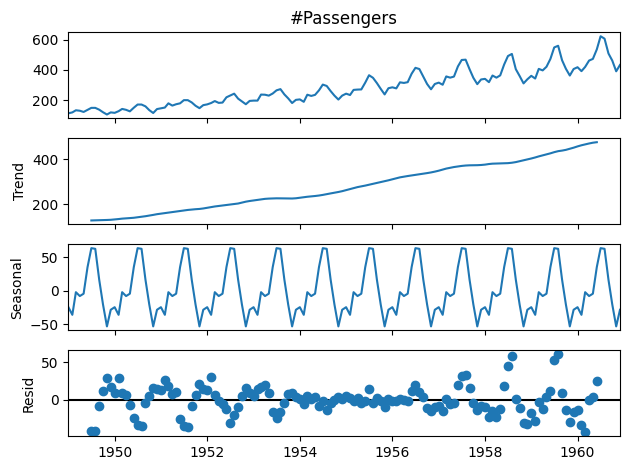

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
results=seasonal_decompose(df['#Passengers'])
results.plot();

In [31]:
df.shape

(144, 1)

In [32]:
train=df.iloc[:132]
test=df.iloc[132:]

In [33]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
sc_train=sc.fit_transform(train)
sc_test=sc.transform(test)


In [34]:
sc_train.shape

(132, 1)

In [37]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input=12
generator=TimeseriesGenerator(sc_train,sc_train,length=n_input,batch_size=1)

In [39]:
generator[0]

(array([[[0.01758242],
         [0.03076923],
         [0.06153846],
         [0.05494505],
         [0.03736264],
         [0.06813187],
         [0.0967033 ],
         [0.0967033 ],
         [0.07032967],
         [0.03296703],
         [0.        ],
         [0.03076923]]]),
 array([[0.02417582]]))

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.fit(generator,epochs=100)

Epoch 1/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0015
Epoch 2/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0015
Epoch 3/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0022
Epoch 4/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0015
Epoch 5/100
120/120 [==============================] - 1s 10ms/step - loss: 0.0016
Epoch 6/100
120/120 [==============================] - 1s 12ms/step - loss: 0.0012
Epoch 7/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0014
Epoch 8/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0014
Epoch 9/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0015
Epoch 10/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0020
Epoch 11/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0017
Epoch 12/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0015
Epoch 13/10

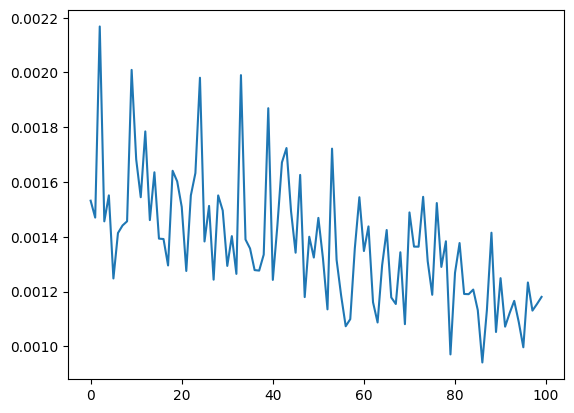

In [60]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [61]:
test_prediction=[]
first_batch=sc_train[-n_input:]
current_batch=first_batch.reshape((1,n_input,1))
for i in range(len(test)):
  current_pred=model.predict(current_batch)[0]
  test_prediction.append(current_pred)
  current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [62]:
test_prediction

[array([0.6051483], dtype=float32),
 array([0.57054377], dtype=float32),
 array([0.6690265], dtype=float32),
 array([0.68896437], dtype=float32),
 array([0.75022006], dtype=float32),
 array([0.9098939], dtype=float32),
 array([1.1106249], dtype=float32),
 array([1.1586894], dtype=float32),
 array([0.9223647], dtype=float32),
 array([0.73468316], dtype=float32),
 array([0.63267136], dtype=float32),
 array([0.6696075], dtype=float32)]

In [63]:
test_prediction=sc.inverse_transform(test_prediction)
test_prediction

array([[379.34248352],
       [363.59741354],
       [408.40705478],
       [417.47878695],
       [445.35012746],
       [518.00171101],
       [609.33433378],
       [631.20366776],
       [523.67594385],
       [438.28083599],
       [391.86546707],
       [408.67142165]])

In [66]:
test['Prediction']=test_prediction

<ipython-input-66-f0765bfc3ed2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction']=test_prediction


In [67]:
test.head()

,#Passengers,Prediction
Month,,
1960-01-01,417,379.342484
1960-02-01,391,363.597414
1960-03-01,419,408.407055
1960-04-01,461,417.478787
1960-05-01,472,445.350127


<Axes: xlabel='Month'>

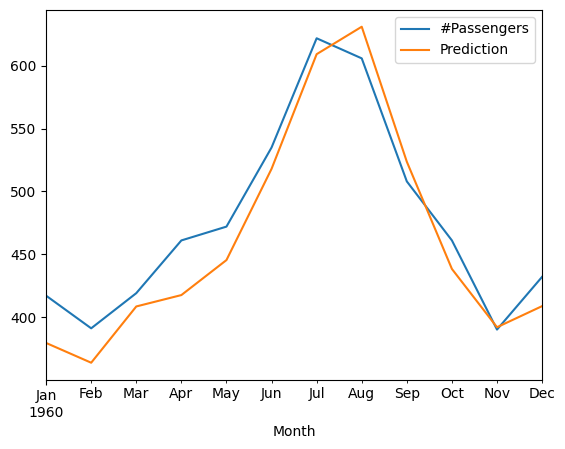

In [68]:
test.plot()

In [71]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse=mean_squared_error(test['#Passengers'],test['Prediction'])
rmse=sqrt(mse)
rmse

24.63009073467412

In [72]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model1=Sequential()
model1.add(LSTM(100,activation='relu',input_shape=(n_input,1)))
model1.add(Dense(1))
model1.compile(optimizer='sgd',loss='mse')

In [73]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [75]:
model1.fit(generator,epochs=50)

Epoch 1/50
120/120 [==============================] - 1s 7ms/step - loss: 0.0342
Epoch 2/50
120/120 [==============================] - 1s 7ms/step - loss: 0.0291
Epoch 3/50
120/120 [==============================] - 1s 7ms/step - loss: 0.0254
Epoch 4/50
120/120 [==============================] - 1s 7ms/step - loss: 0.0221
Epoch 5/50
120/120 [==============================] - 1s 8ms/step - loss: 0.0193
Epoch 6/50
120/120 [==============================] - 1s 8ms/step - loss: 0.0165
Epoch 7/50
120/120 [==============================] - 1s 12ms/step - loss: 0.0146
Epoch 8/50
120/120 [==============================] - 1s 7ms/step - loss: 0.0131
Epoch 9/50
120/120 [==============================] - 1s 8ms/step - loss: 0.0118
Epoch 10/50
120/120 [==============================] - 1s 8ms/step - loss: 0.0110
Epoch 11/50
120/120 [==============================] - 1s 8ms/step - loss: 0.0104
Epoch 12/50
120/120 [==============================] - 1s 8ms/step - loss: 0.0102
Epoch 13/50
120/120 [===

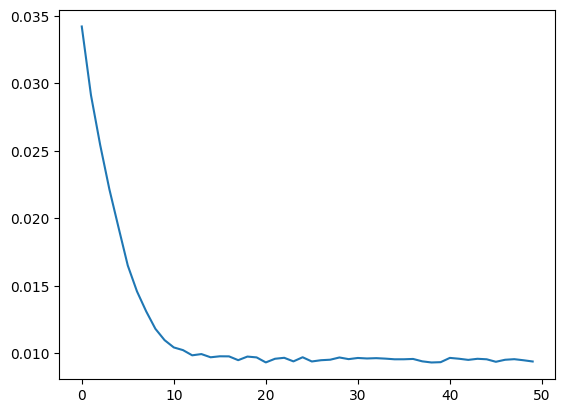

In [76]:
loss_per_epoch1=model1.history.history['loss']
plt.plot(range(len(loss_per_epoch1)),loss_per_epoch1)

In [86]:
test_prediction1=[]
first_batch1=sc_train[-n_input:]
current_batch1=first_batch1.reshape((1,n_input,1))
for i in range(len(test)):
  current_pred1=model1.predict(current_batch1)[0]
  test_prediction1.append(current_pred1)
  current_batch1=np.append(current_batch1[:,1:,:],[[current_pred1]],axis=1)

1/1 [==============================] - 0s 35ms/step


In [87]:
test_prediction1

[array([0.73378897], dtype=float32),
 array([0.74063456], dtype=float32),
 array([0.7474667], dtype=float32),
 array([0.7520081], dtype=float32),
 array([0.7566867], dtype=float32),
 array([0.76043844], dtype=float32),
 array([0.7624559], dtype=float32),
 array([0.7621526], dtype=float32),
 array([0.76150835], dtype=float32),
 array([0.7634528], dtype=float32),
 array([0.7670108], dtype=float32),
 array([0.77194047], dtype=float32)]

In [88]:
test_prediction1=sc.inverse_transform(test_prediction1)

In [89]:
test['Prediction1']=test_prediction1

<ipython-input-89-6549e6d7bf41>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction1']=test_prediction1


In [90]:
test.head()

,#Passengers,Prediction,Prediction1
Month,,,
1960-01-01,417,379.342484,437.873980
1960-02-01,391,363.597414,440.988725
1960-03-01,419,408.407055,444.097341
1960-04-01,461,417.478787,446.163677
1960-05-01,472,445.350127,448.292443


<Axes: xlabel='Month'>

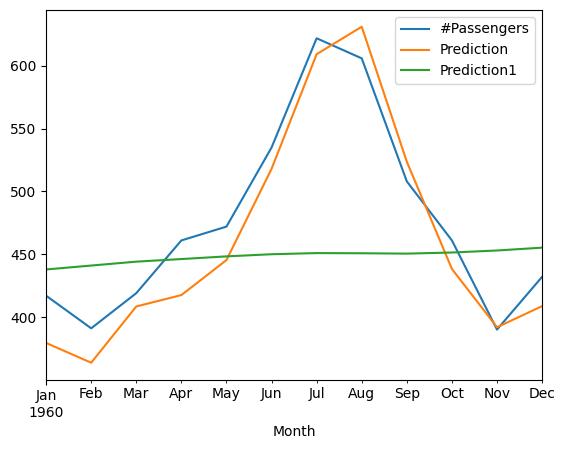

In [91]:
test.plot()

In [92]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse=mean_squared_error(test['#Passengers'],test['Prediction1'])
rmse=sqrt(mse)
rmse

77.91150659675142